# Praca domowa 3 - Bartosz Rożek

Pracuję na zbiorze projektowym - ceny mieszkań w Kalifornii

In [1]:
setwd("/home/bartosz/Documents/studia/sem6/wb2/")

Wczytanie zbioru i jakiś preprocessing

In [2]:
housing <- read.csv("housing.csv")

housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')

housing = housing[ , !(names(housing) %in% drops)]
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "population"         "households"         "median_income"     
 [7] "median_house_value" "ocean_proximity"    "mean_bedrooms"     
[10] "mean_rooms"

In [3]:
set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(housing), size = floor(.8*nrow(housing)), replace = F)
train = housing[sample, ] #just the samples
test  = housing[-sample, ] #everything but the samples

In [4]:
train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

## Model

Używam modelu z kaggle - random forest

In [5]:
library('randomForest')
rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



In [6]:
library(DALEX)
library(DALEXtra)
explainer_rf <- DALEX::explain(model = rf_model,
                     data = test[,-7],
                     y = test$median_house_value)

Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/


Anaconda not found on your computer. Conda related functionality such as create_env.R and condaenv and yml parameters from explain_scikitlearn will not be available



Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  4128  rows  9  cols 
  -> target variable   :  4128  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  49646.46 , mean =  207761.7 , max =  499426.2  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -296358.5 , mean =  460.0371 , max =  334253.2  
  A new explainer has been created!  


# PDP

In [7]:
pdp_1 <- model_profile(explainer_rf)

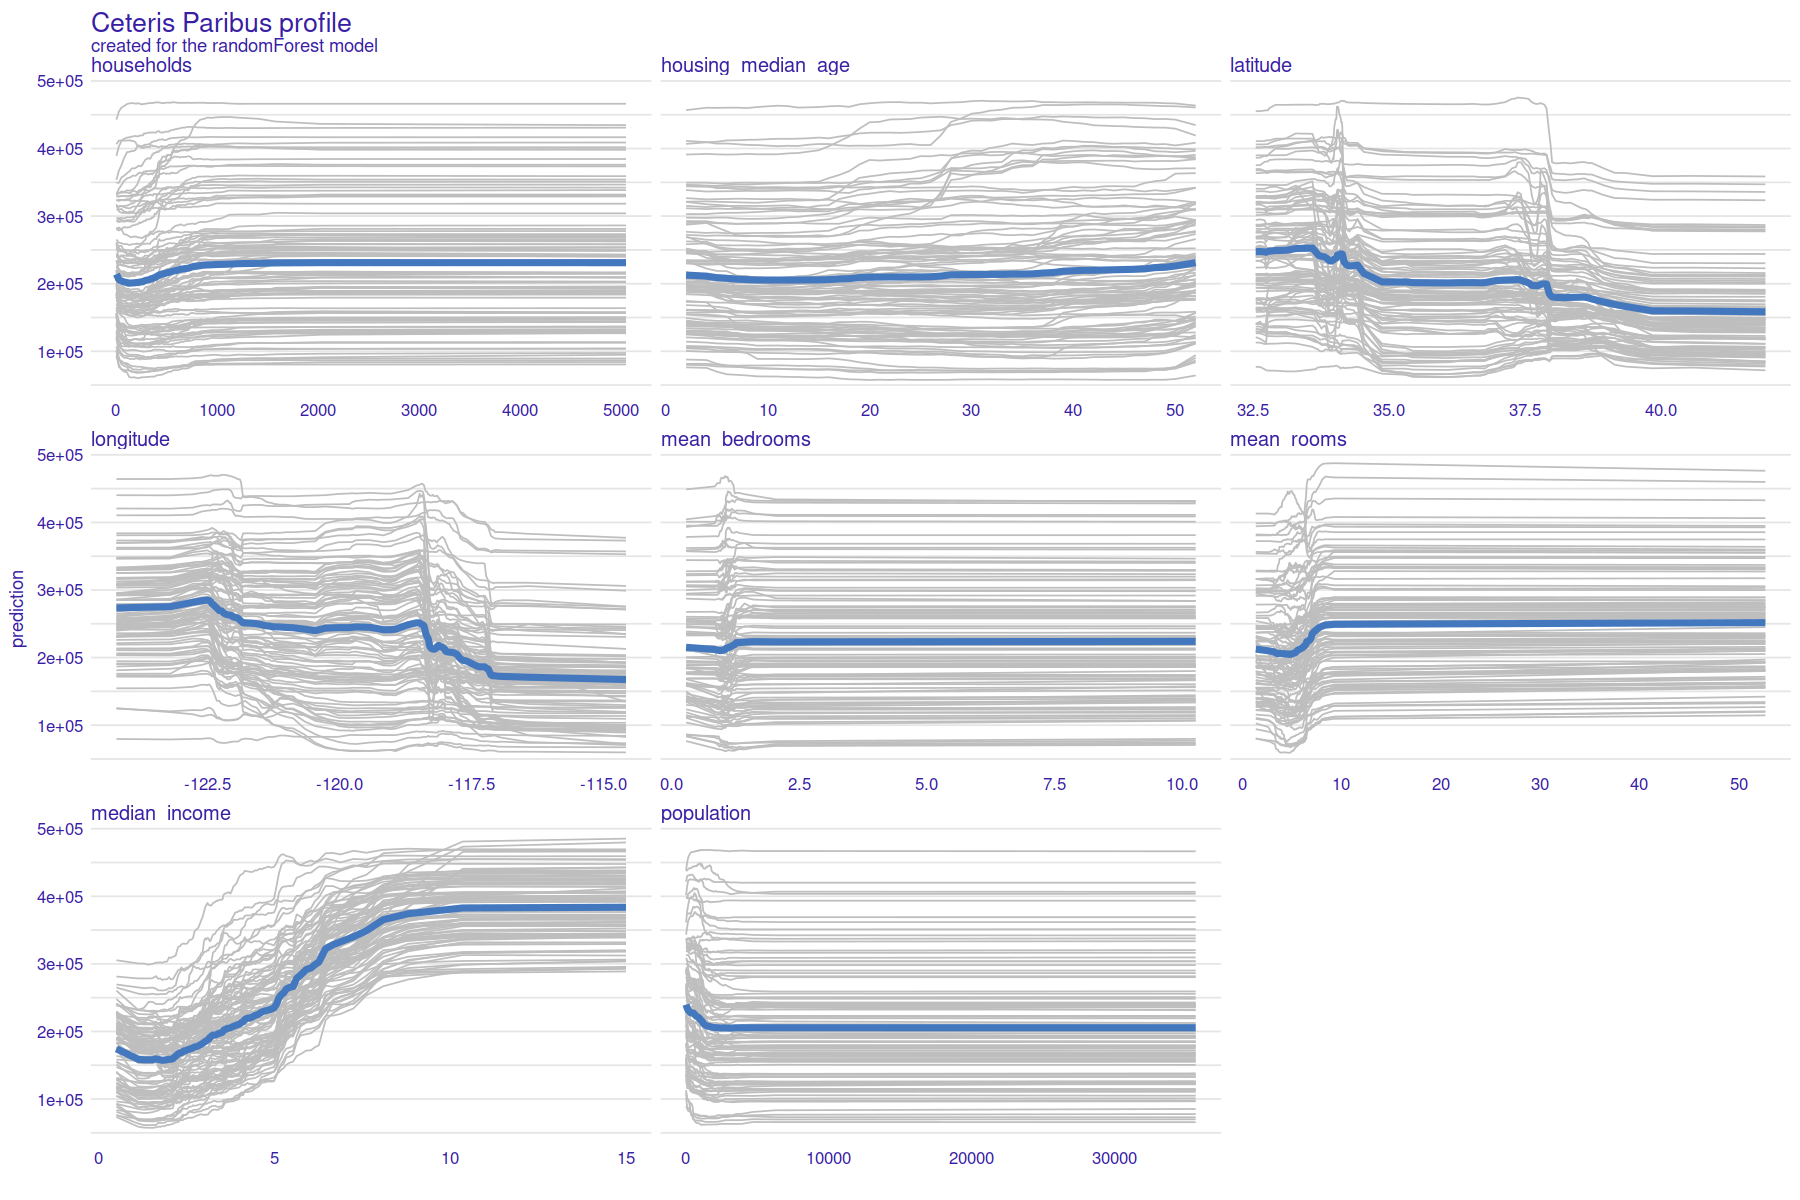

In [10]:
options(repr.plot.width=15, repr.plot.height=10)
plot(pdp_1, geom = "profiles")

Widać, że wnioski płynące z PDP pokrywają się z wnioskami uzyskanymi poprzednio - większość zmiennych ma nikły wpływ, poza długością i szerokością geograficzną oraz medianą wpływu. 

In [25]:
pdp_1 <- model_profile(explainer_rf, N = 100, grid_points = 100, groups="ocean_proximity" )

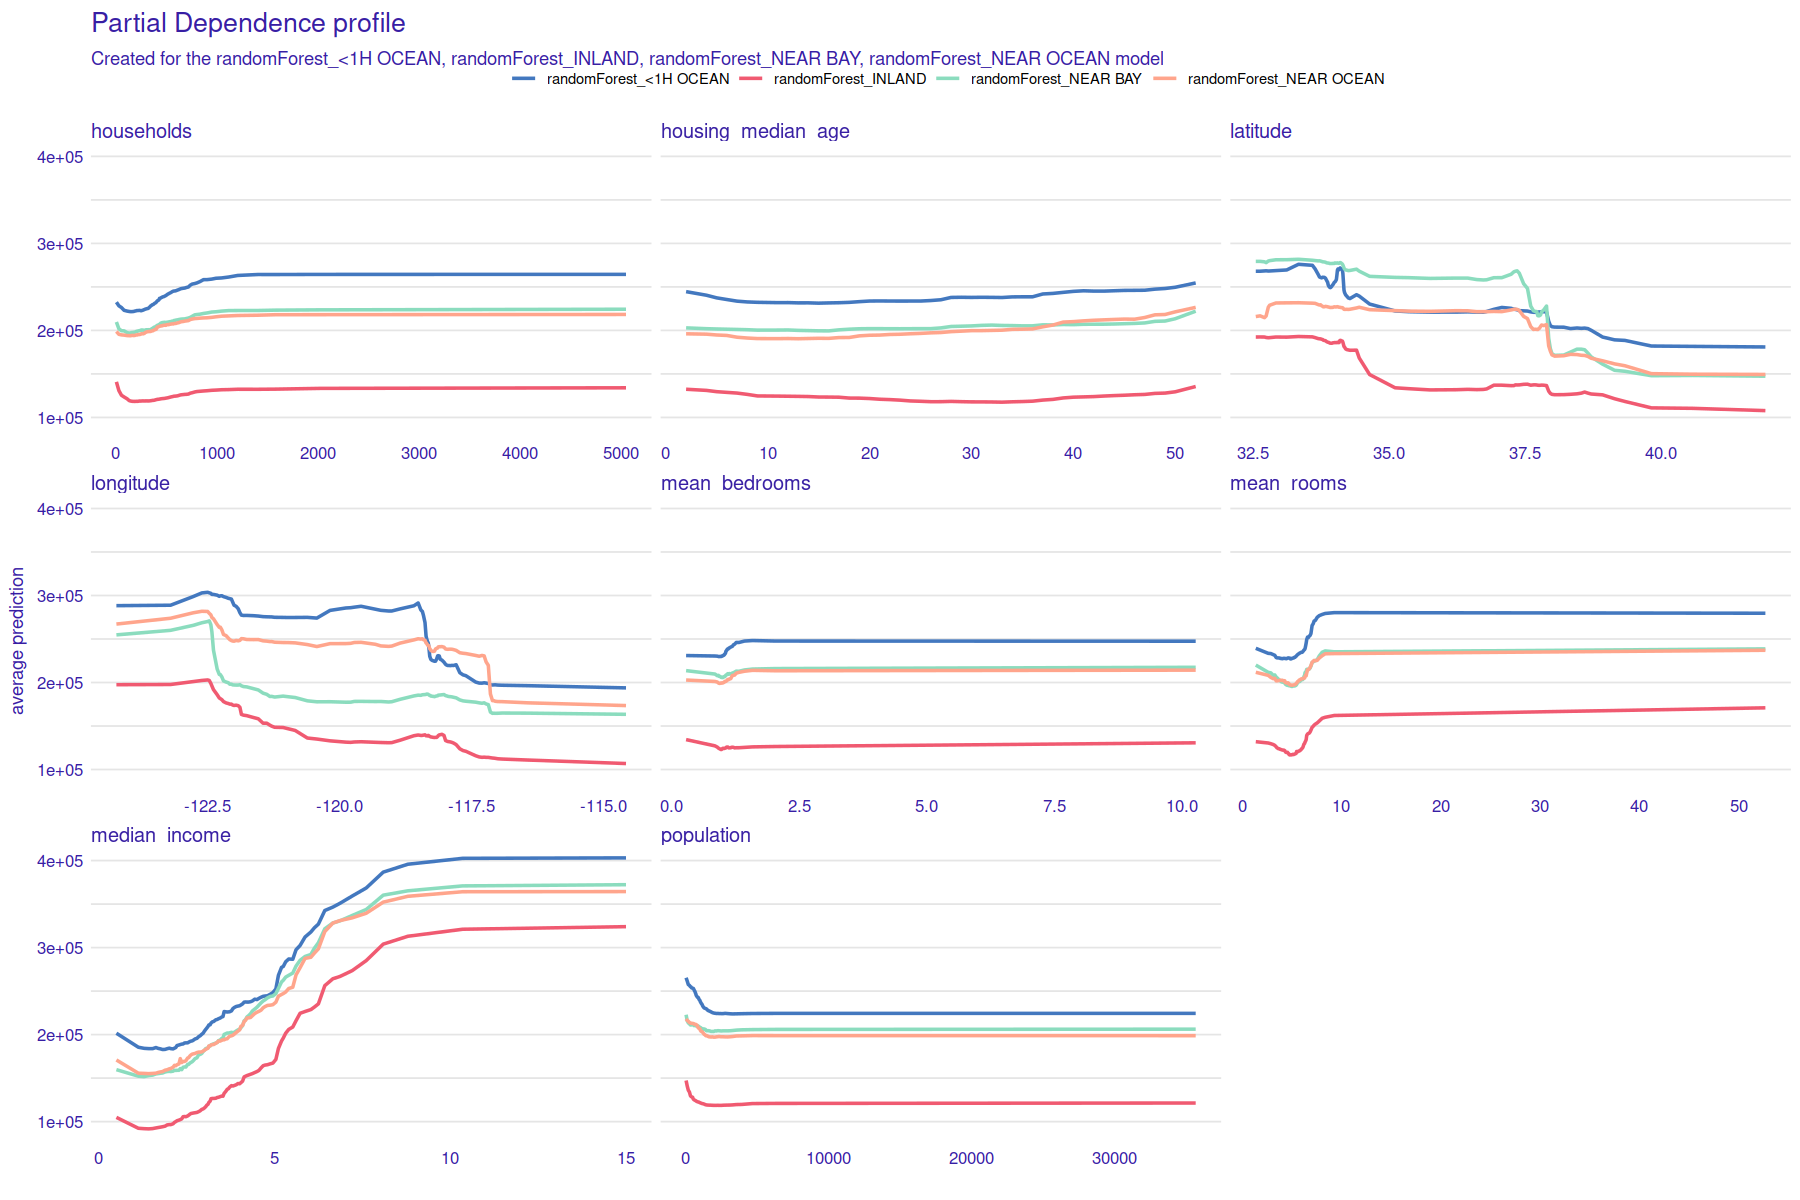

In [26]:
plot(pdp_1)

Patrząc na PDP podzielone według położenia nieruchomości względem oceanu widać, że najtańsze są domy w środku kontynentu, natomiast najdroższe te godzinę drogi od oceanu. Domy blisko oceanu i blisko mają podobne ceny. Zazwyczaj, niezależnie od położenia, przebieg zmiany ceny jest bardzo podobny.

# ALE

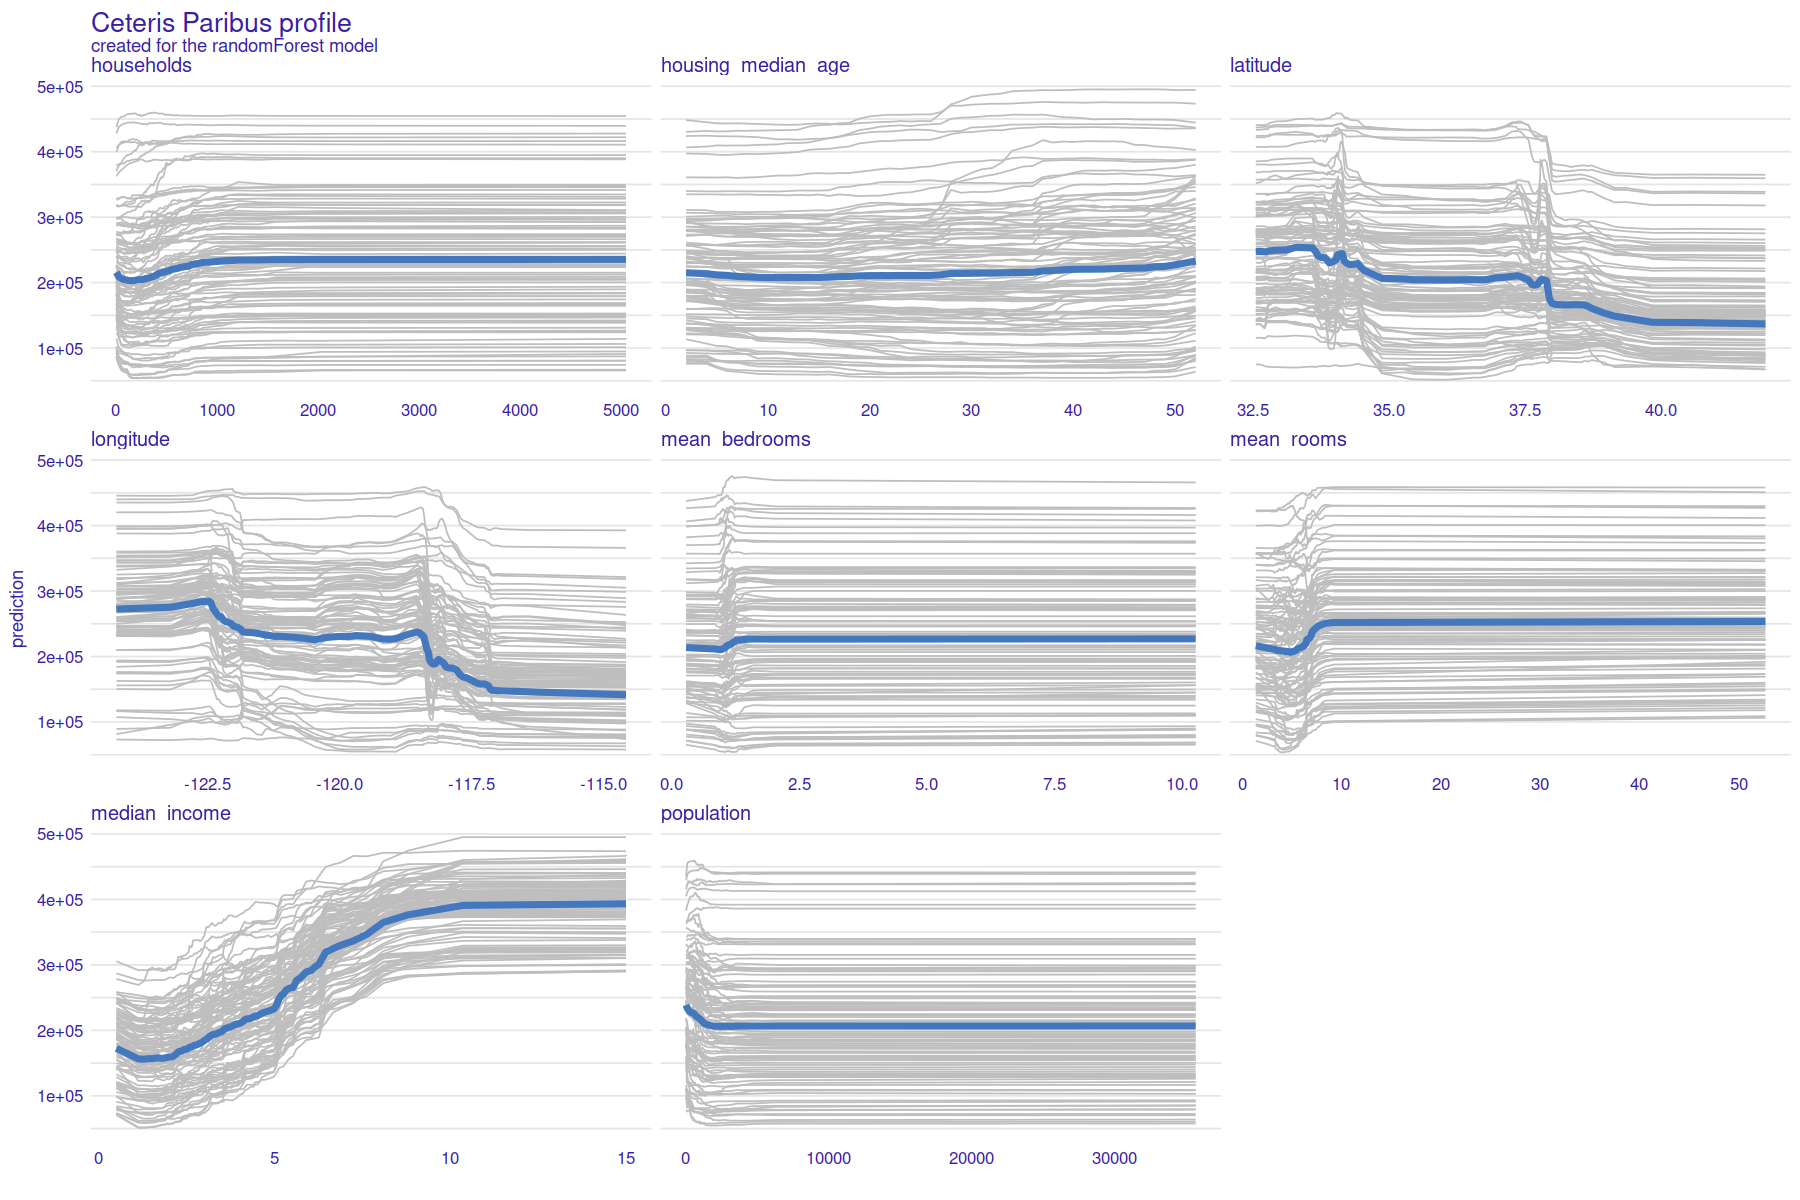

In [12]:
ale_1 <- model_profile(explainer_rf, type = "accumulated")
plot(ale_1, geom = "profiles")

Po wpatrywaniu się w wykres PDP i ALE jedyne różnice jakie jestem w stanie zauważyć to delikatnie inny skok w *latitude*.

# Różne siatki

In [45]:
pdp_1 <- model_profile(explainer_rf, N = 1000, grid_points = 100, variable_splits_type = "uniform")
pdp_2 <- model_profile(explainer_rf, N = 1000, grid_points = 100)

In [46]:
pdp_1$agr_profiles$`_label_` <- "rF uniform"

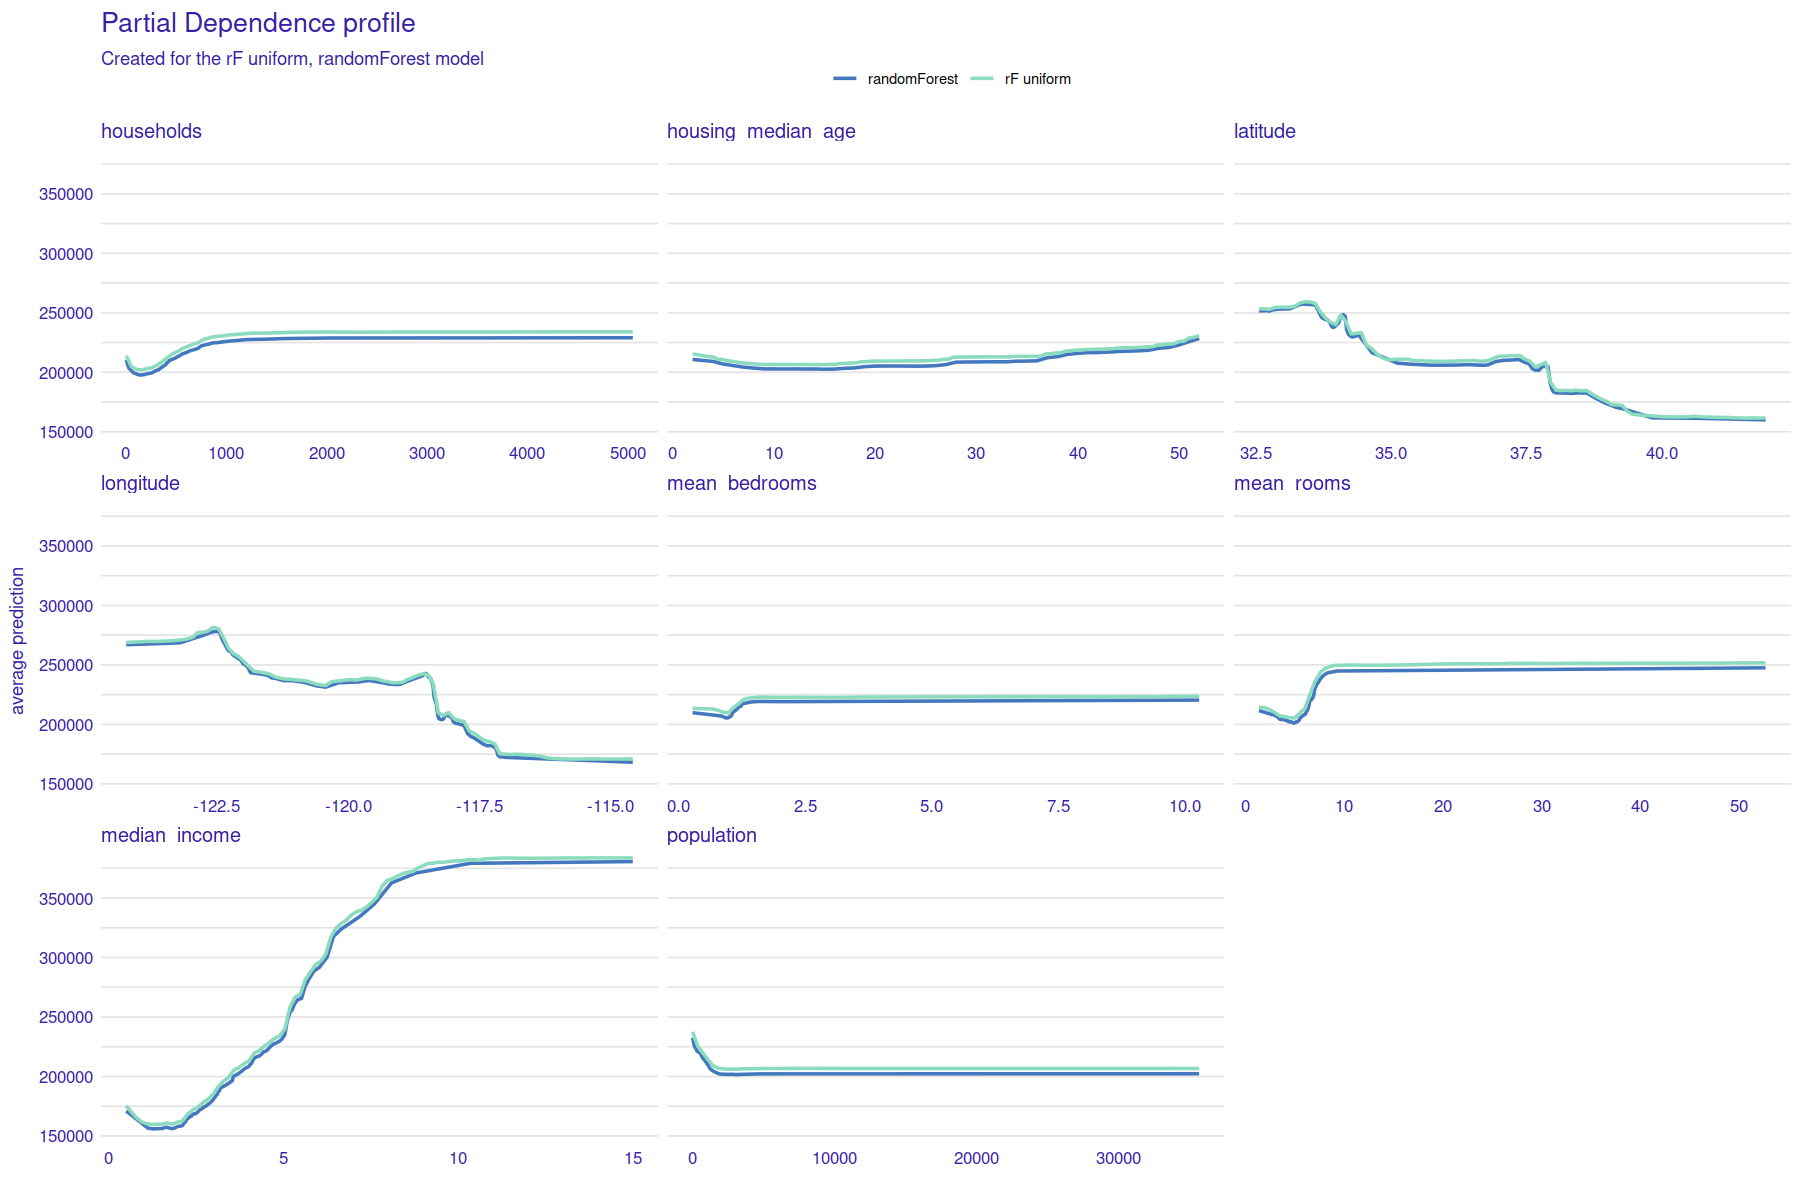

In [47]:
plot(pdp_1, pdp_2)

Wykres przy jednostajnym rozkładzie jest bardzo podobna co dla domyślnego.

In [51]:
pdp_1 <- model_profile(explainer_rf, N = 1000, grid_points = 10)
pdp_2 <- model_profile(explainer_rf, N = 1000, grid_points = 100)

In [52]:
pdp_1$agr_profiles$`_label_` <- "rF grid = 10"
pdp_2$agr_profiles$`_label_` <- "rF grid = 100"

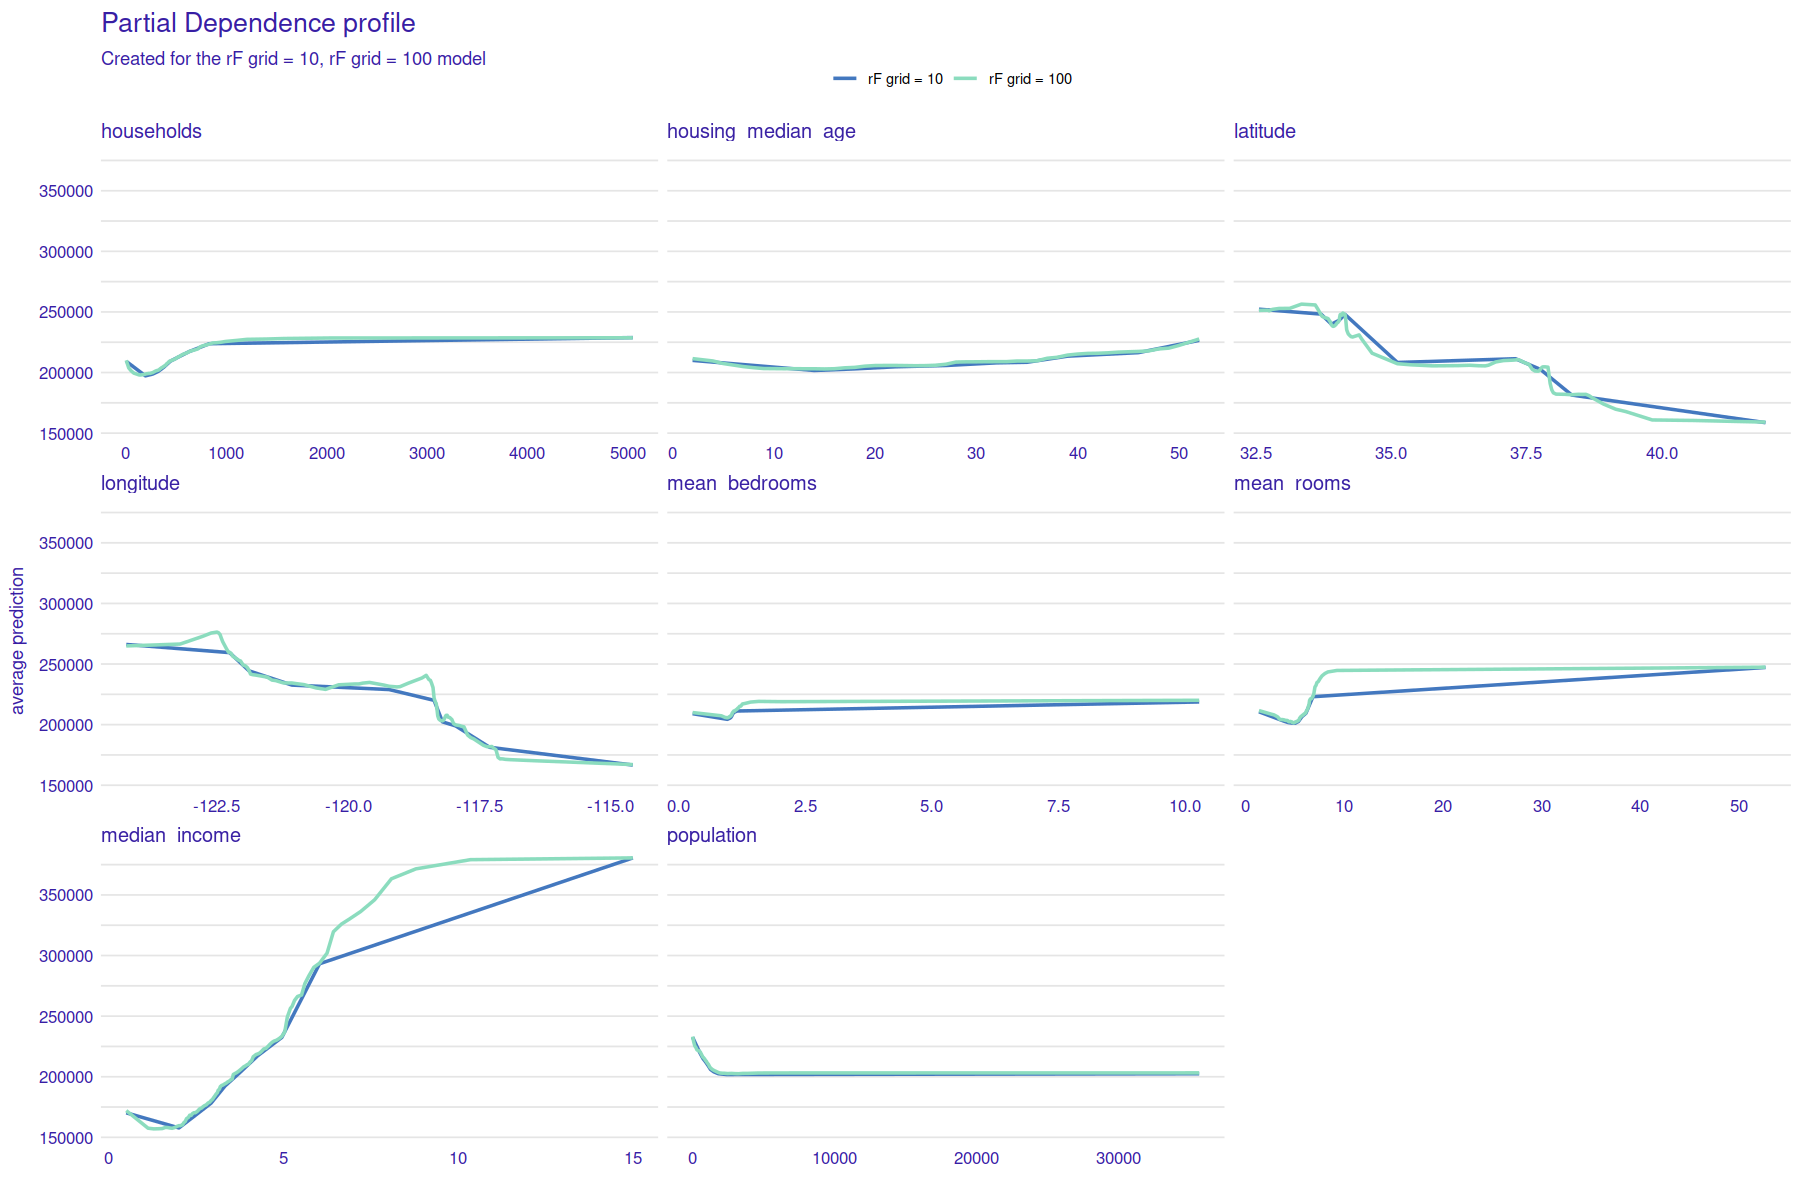

In [53]:
plot(pdp_1, pdp_2)

Jak widać, mniejsza siatka "upraszcza" wykres funkcji, co jest całkowicie naturalne. Mimo wszystko, zachowuje główny "trend" przebiegu i zachowania się ceny posiadłości.

In [39]:
pdp_1 <- model_profile(explainer_rf, N = 1000, grid_points = 100)
pdp_2 <- model_profile(explainer_rf, N = 100, grid_points = 100)

In [40]:
pdp_1$agr_profiles$`_label_` <- "rF N = 1000"
pdp_2$agr_profiles$`_label_` <- "rF N = 100"

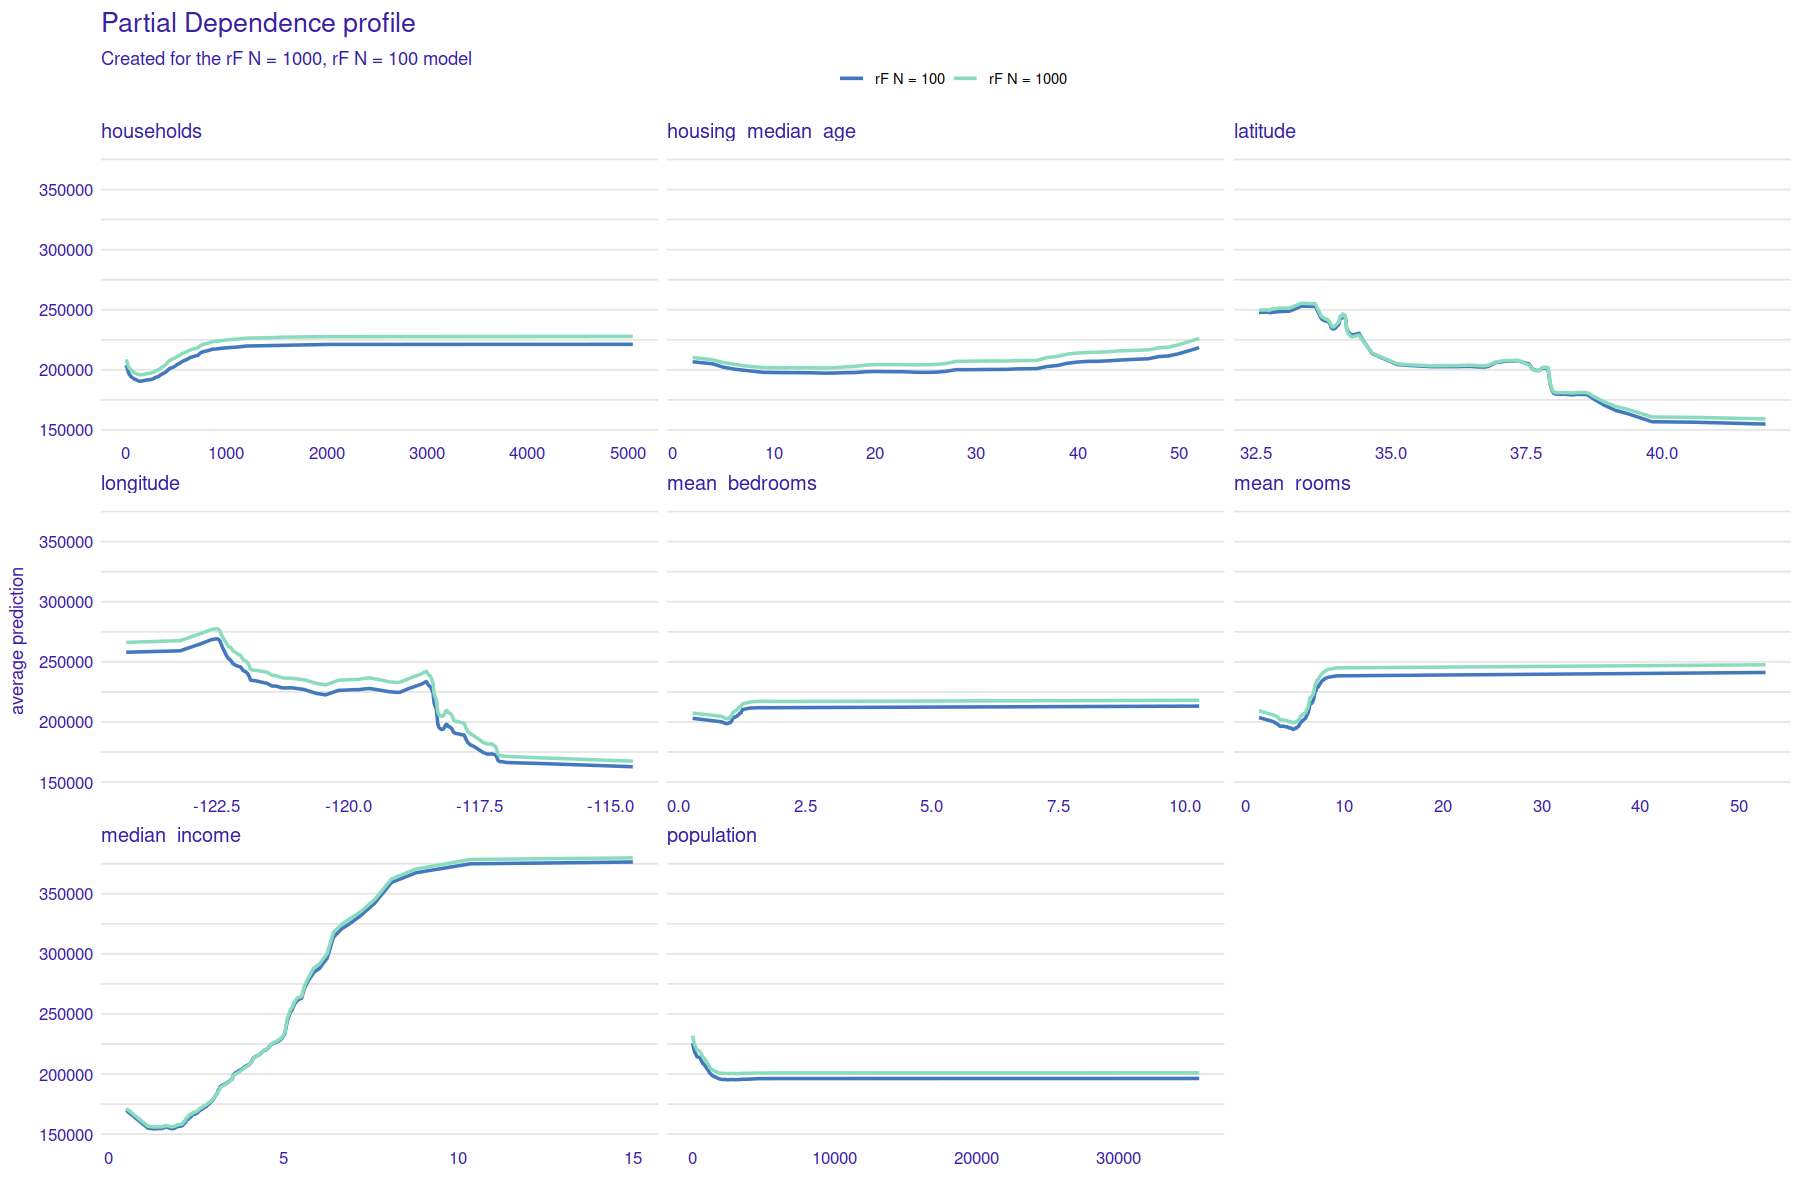

In [41]:
plot(pdp_1, pdp_2)

Funkcje dla różnych *n* mają bardzo podobny przebieg, jednak są przesunięte między sobą. Różnica w wykresach wynika z losowości, co jest naturalne, że w zależności od wielkości próby będą się one różnić. Dziwnym wydawać może się fakt że kształy są podobne, jednak możemy to wyjaśnić patrząc na pierwszy wykres z pracy domowej - niezależnie od kosztu danego mieszkania, przebieg jego ceny jest bardzo podobny.

# Bonus

In [61]:
library(fda.usc)
library(fda)
library(depthTools)
library(stringi)

In [79]:
sam <- sample.int(n = nrow(housing), size = 1000, replace = F)
obs <- housing[sam, -7]

In [80]:
options(repr.plot.width=15, repr.plot.height=10)
cp_rf <- predict_profile(explainer_rf, obs)

In [81]:
plot_ceteris_boxplot <- function(variable, pp){
    funs <- matrix(cp_rf[( cp_rf$`_vname_`==variable),'_yhat_'], nrow = length(unique(cp_rf$`_ids_`)), byrow=TRUE)
    values <- cp_rf[( cp_rf$`_vname_`==variable),variable] 
    funs_moved <- t(apply(funs, 1, function(x) x - lm(x~1)$coefficients))
    fdata_ceteris <- fdata(funs_moved, values[1:101])
    fda_ceteris <- Data2fd(fdata_ceteris$argval,t(fdata_ceteris$data))
    mean_function <- apply(funs_moved, 2, mean)
    boxplot.fd(fda_ceteris,col=7,main=paste("Ceteris Paribus functional boxplot for", stringr::str_to_title(variable)), 
               outlier ="darkblue")
    lines(values[1:101],mean_function , col="red", lwd=3, lty=3)
}

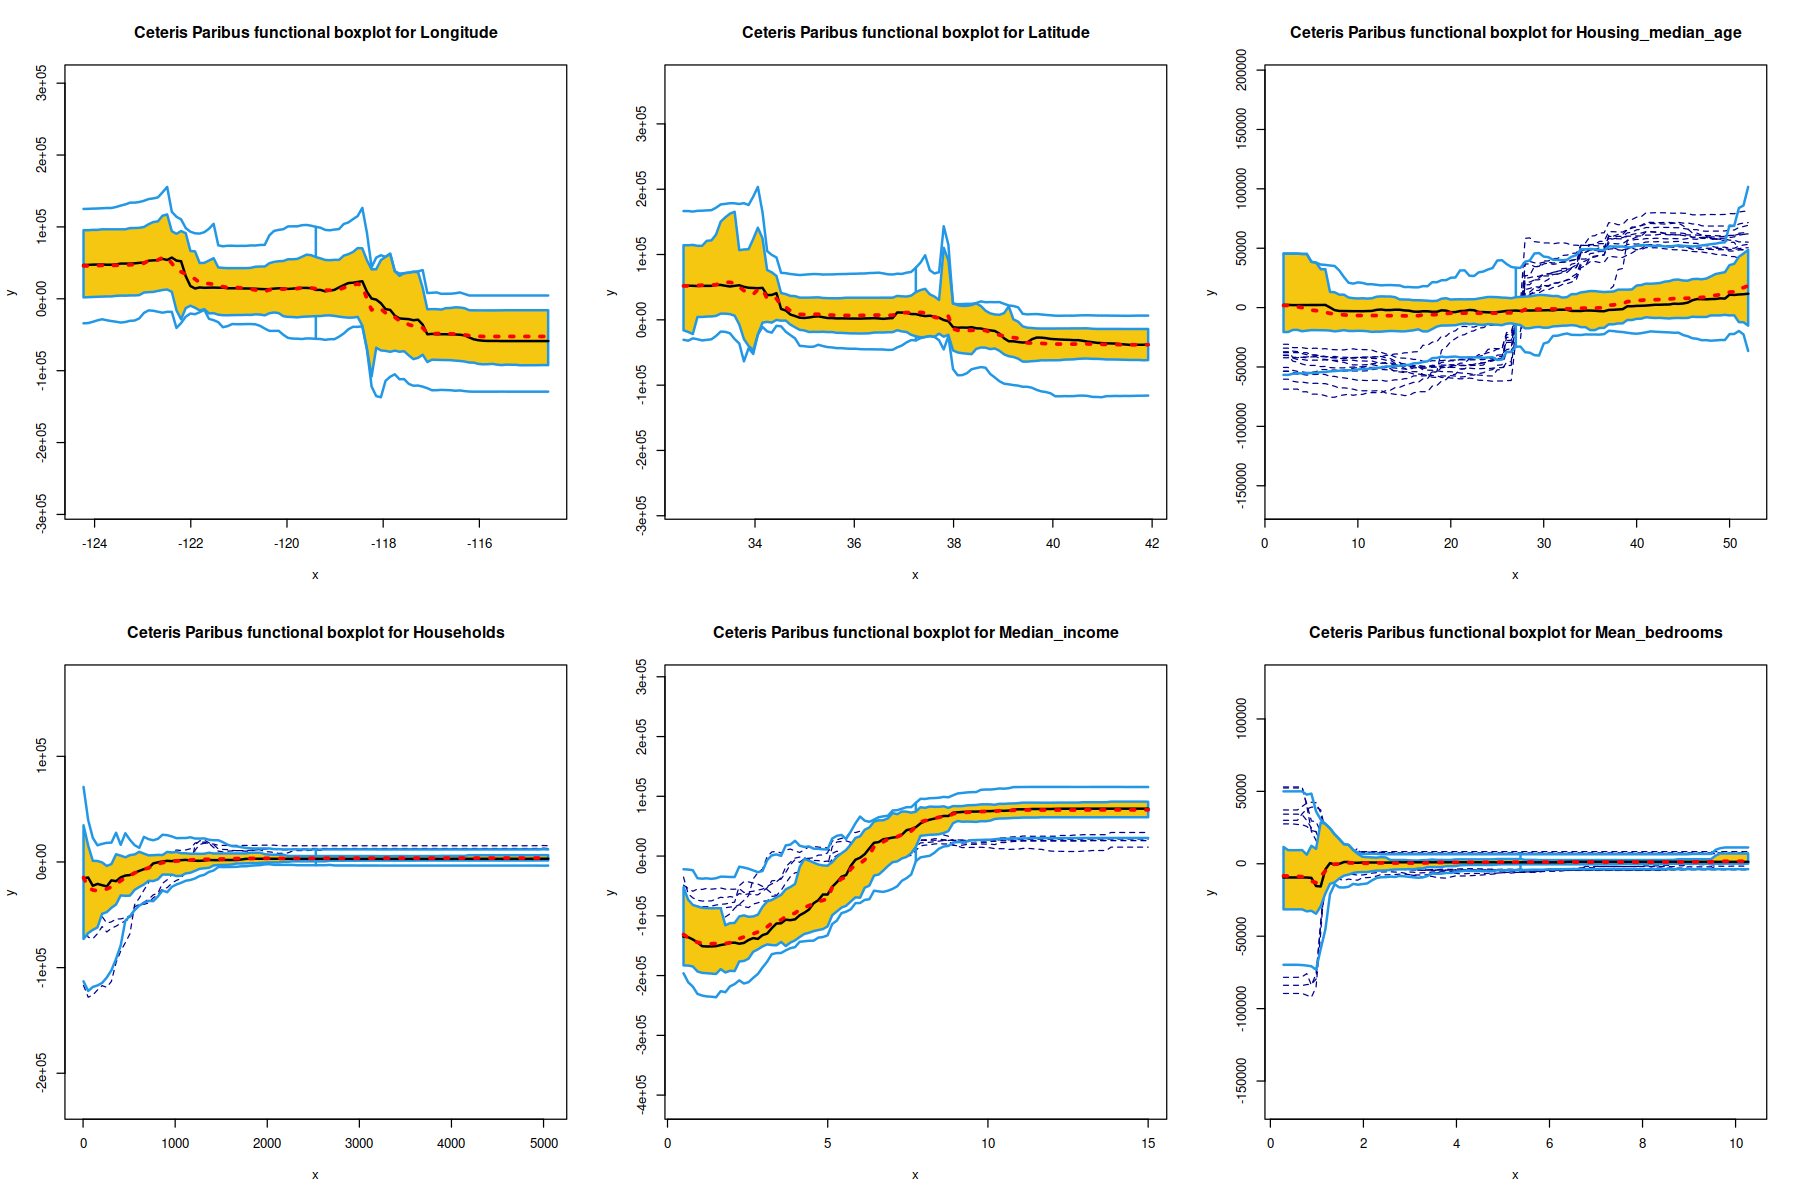

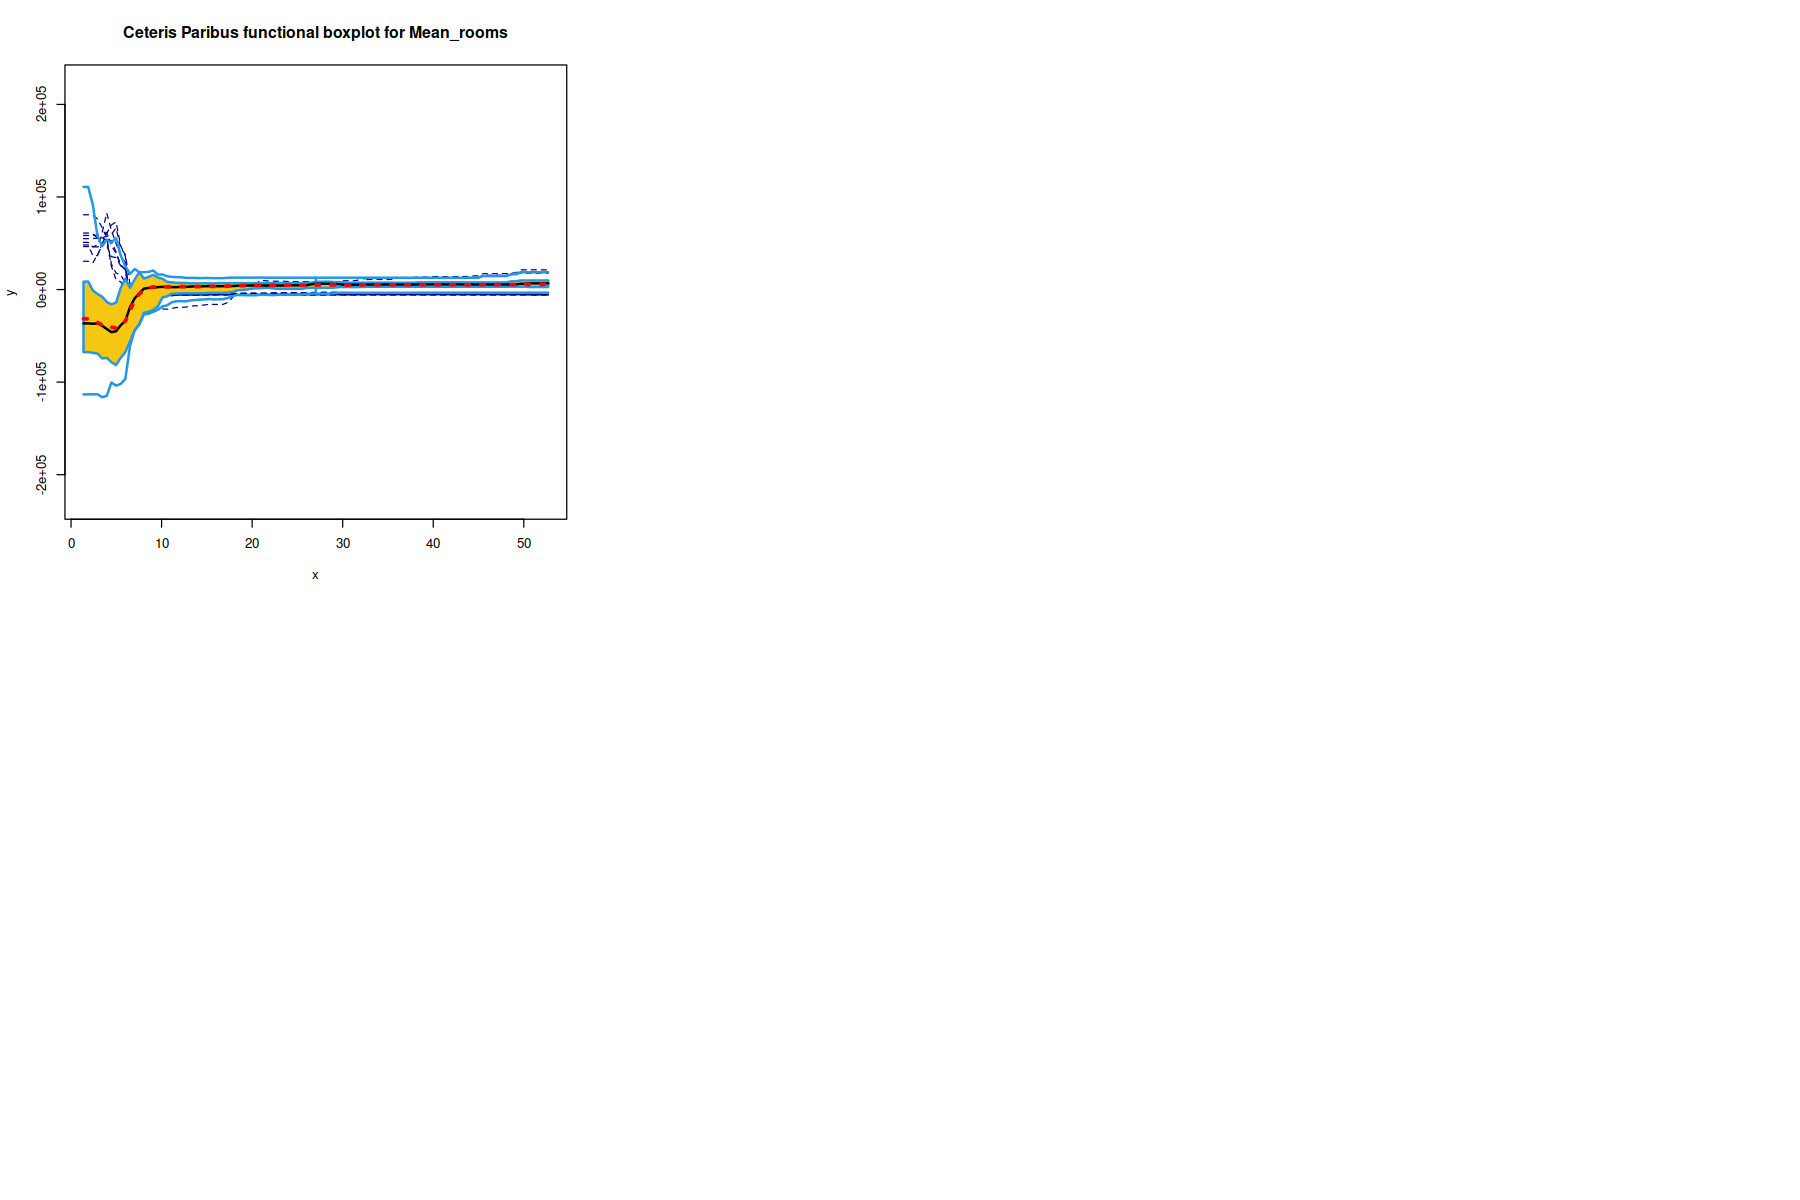

In [82]:
variables <- colnames(housing)[-c(4,7,8)]
par(mfrow=c(2,3))
plot_ceteris_boxplots <- sapply(variables, plot_ceteris_boxplot, pp = cp_rf)

Powyższe wykresy są PDP na sterydach, korzystam z funkcjonalnego boxplotu do pokazania jak przebiega funkcja. Funkcjonalny boxplot opiera się na pojęciu głębi. Głębia mówi nam jak centralnie położona jest dana obserwacja (dla nas funkcja). Na wykresie czerwona przerywana linia jest średnią funkcji, czarna linia to mediana, czyli funkcja o największej głębi, żółty obszar to region centralny (50% obserwacji najgłębszych), zewnętrzne linie błękitne to wąsy, a przerywane linie granatowe to outliery. Żeby w ogóle analizować te funkcje pod kątem głębi na początku przesuwam wszystkie funkcje tak aby zminimalizować SSE względem osi x. 

Taka wizualizacja pozwala lepiej zaobserwować outliery, a dodatkowo szerokość regionu centralnego ukazuje zmienność funkcji w danym przedziale.

Tutaj:
- dla latitude widzimy szeroki region centralny dla małych wartości, czyli tym odpowiadającym okolicy Los Angeles oraz dziwny skok przy wartościach odpowiadającym San Francisco
- dla housing_median_age widzimy outliery dla nieruchomości, które mają duży skok dla ~30 lat
- dla mean_bedroms i mean_rooms widzimy, wąsy obejmują wzrost i spadek median_house_value dla małych wartości zmniennych

Sam to wymyśliłem, więc nie obiecuje że to do całkowicie ma sens

Ale wygląda fajnie